In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from grid2op.PlotGrid import PlotMatplot
import grid2op
from dataclasses import dataclass
import scipy
import ipdb

import torch
from torch_geometric.data import Data


In [2]:
import os
from grid2op import make

# Initialize the env.
env = make("rte_case14_realistic")

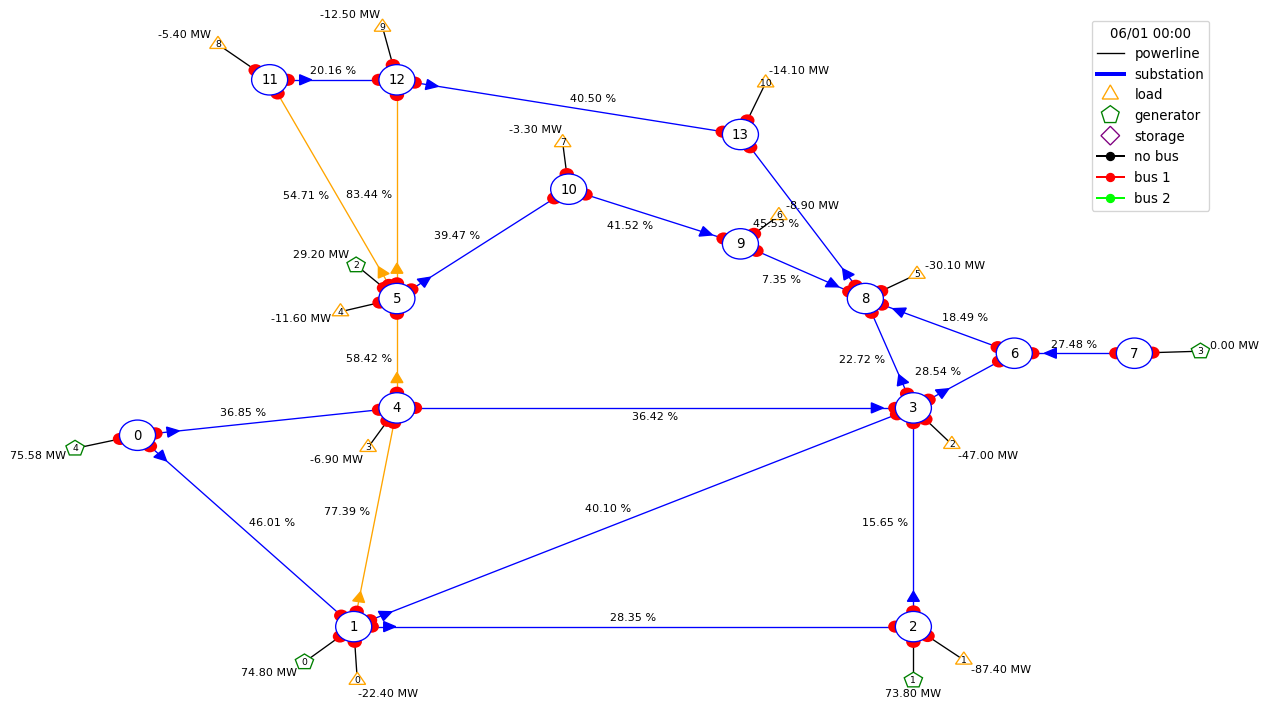

In [3]:
plot_helper = PlotMatplot(env.observation_space)

obs = env.reset()
fig = plot_helper.plot_obs(obs)

In [4]:
@dataclass
class Gen:
    '''
    Dataclass for the static features of a generator
    '''
    id: int
    sub_id: int #Id of the substation
    sub_pos: int #position (RELATIVE) at its substation
    pos: int #position (ABSOLUTE)
        
gens = [Gen(*x) for x in zip(list(range(env.observation_space.n_gen)),
    env.observation_space.gen_to_subid,
    env.observation_space.gen_to_sub_pos,
    env.observation_space.gen_pos_topo_vect)]

@dataclass
class Load:
    '''
    Dataclass for the static features of a load
    '''
    id: int
    sub_id: int #Id of the substation
    sub_pos: int #position (RELATIVE) at its substation
    pos: int #position (ABSOLUTE)
        
loads = [Load(*x) for x in zip(list(range(env.observation_space.n_load)),
    env.observation_space.load_to_subid,
    env.observation_space.load_to_sub_pos,
    env.observation_space.load_pos_topo_vect)]

@dataclass
class PowerLine:
    '''
    Dataclass for the static features of a powerline
    '''
    id: int
    or_sub_id: int #Id of the origin substation
    ex_sub_id: int #Id of the extremity substation
    or_sub_pos: int #Origin position (RELATIVE) at its substation
    ex_sub_pos: int #Extremity position (RELATIVE) at its substation
    or_pos: int #Origin position (ABSOLUTE)
    ex_pos: int #Extremity position (ABSOLUTE)
        
lines = [PowerLine(*x) for x in zip(list(range(env.observation_space.n_line)),
    env.observation_space.line_or_to_subid,
    env.observation_space.line_ex_to_subid,
    env.observation_space.line_or_to_sub_pos,
    env.observation_space.line_ex_to_sub_pos,
    env.observation_space.line_or_pos_topo_vect,
    env.observation_space.line_ex_pos_topo_vect)]

In [5]:
env.observation_space.n_line

20

In [6]:
action_space = env.action_space
observation_space = env.observation_space

# Create do_nothing action.
agent_action = action_space({})
obs, *_ = env.step(agent_action)
# TODO: 'obs' does not contain all attributes, e.g. time

In [7]:
def extract_gen_features(obs: grid2op.Observation.CompleteObservation):
    i = obs.gen_pos_topo_vect
    X = np.array(list(obs.to_dict()['gens'].values())).T
    return i,X

def extract_load_features(obs: grid2op.Observation.CompleteObservation):
    i = obs.load_pos_topo_vect
    X = np.array(list(obs.to_dict()['loads'].values())).T
    return i,X

def extract_or_features(obs: grid2op.Observation.CompleteObservation):
    i = obs.line_or_pos_topo_vect
    X = np.array(list(obs.to_dict()['lines_or'].values())).T
    X = np.concatenate((X,np.reshape(np.array(obs.to_dict()['rho']),(-1,1))),axis=1)
    return i,X

def extract_ex_features(obs: grid2op.Observation.CompleteObservation):
    i = obs.line_ex_pos_topo_vect
    X = np.array(list(obs.to_dict()['lines_ex'].values())).T
    X = np.concatenate((X,np.reshape(np.array(obs.to_dict()['rho']),(-1,1))),axis=1)
    return i,X

Toying around with PyG

In [8]:
N_features = 3+5
n=observation_space.n_gen+observation_space.n_load+2*observation_space.n_line
N_classes=4

def extract_features_zero_impunement(obs: grid2op.Observation.CompleteObservation):
    X=np.zeros((n,N_features))
    T=np.zeros(n)
    for t,f in enumerate([extract_gen_features,extract_load_features,extract_or_features,extract_ex_features]):
        if t < 2:
            for i,x in zip(*f(obs)):
                X[i,:3]=x
                T[i]=t
        else:
            for i,x in zip(*f(obs)):
                X[i,3:]=x   
                T[i]=t
    return X,T

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

conmatrix = obs.connectivity_matrix(as_csr_matrix=True)
conmatrix = conmatrix - scipy.sparse.identity(conmatrix.shape[0])
coo_conmatrix = conmatrix.tocoo()
edges = zip(coo_conmatrix.row,coo_conmatrix.col)

X,T = extract_features_zero_impunement(obs)

i_gen,X_gen = extract_gen_features(obs)
i_load,X_load = extract_load_features(obs)
i_or,X_or = extract_or_features(obs)
i_ex,X_ex = extract_ex_features(obs)
    
edge_index=torch.tensor(list(edges),dtype=torch.long,device=device).T
T = torch.tensor(T,dtype=torch.long,device=device)

In [10]:
from torch_geometric.nn import  SAGEConv, Linear
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.lin_gen_1 = Linear(3,32)
        self.lin_gen_2 = Linear(32,32)
        
        self.lin_load_1 = Linear(3,32)
        self.lin_load_2 = Linear(32,32)
     
        self.lin_or_1 = Linear(5,32)
        self.lin_or_2 = Linear(32,32)
        
        self.lin_ex_1 = Linear(5,32)
        self.lin_ex_2 = Linear(32,32)
        
        self.conv1 = SAGEConv(32,32,root_weight=False,aggr='add')
        self.conv2 = SAGEConv(32,4,root_weight=False,aggr='add')
        

    def forward(self, x_gen, x_load, x_or, x_ex, i_gen, i_load, i_or, i_ex, edge_index):
        
        ### Linear layers for different objects ###
        x_gen = self.lin_gen_1(x_gen)
        x_gen = torch.sigmoid(x_gen)
        x_gen = self.lin_gen_2(x_gen)
        x_load = self.lin_load_1(x_load)
        x_load = torch.sigmoid(x_load)
        x_load = self.lin_load_2(x_load)
        x_or = self.lin_or_1(x_or)
        x_or = torch.sigmoid(x_or)
        x_or = self.lin_or_2(x_or)
        x_ex = self.lin_ex_1(x_ex)
        x_ex = torch.sigmoid(x_ex)
        x_ex = self.lin_ex_2(x_ex)
        
        ### Combining different objects ###
        x_gen = torch.cat([i_gen.reshape(-1,1),x_gen],axis=1)
        x_load = torch.cat([i_load.reshape(-1,1),x_load],axis=1)
        x_or = torch.cat([i_or.reshape(-1,1),x_or],axis=1)
        x_ex = torch.cat([i_ex.reshape(-1,1),x_ex],axis=1)
        
        x = torch.cat([x_gen,x_load,x_or,x_ex],axis=0)
        x = torch.stack(sorted(x, key=lambda a: a[0])) #Sorting each time might be slow
        x = x[:,1:]

        ### Graph convolution layer ###
        x = self.conv1(x, edge_index)
        x = torch.sigmoid(x)
        x = self.conv2(x, edge_index)
        
        return F.softmax(x, dim=1)

In [11]:
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)#, weight_decay=5e-4)

X_gen,X_load, X_or, X_ex,i_gen, i_load, i_or, i_ex = [torch.tensor(X,dtype=torch.float,device=device) for X in 
                                                      [X_gen,X_load, X_or, X_ex,i_gen, i_load, i_or, i_ex]]

# episodes = 4
# for _ in episodes:
#     terminated=False
#     while not terminated:
model.train()
for epoch in range(4000):
    optimizer.zero_grad()
    out = model(X_gen, X_load, X_or, X_ex, i_gen, i_load, i_or, i_ex, edge_index)
    loss = torch.nn.NLLLoss()(out, T)
    loss.backward()
    optimizer.step()



    #print(loss)
    #print(out)

In [12]:
T

tensor([2, 2, 0, 3, 2, 2, 2, 0, 1, 3, 2, 0, 1, 3, 3, 2, 2, 2, 1, 3, 3, 3, 2, 1,
        2, 2, 2, 3, 0, 1, 3, 2, 3, 3, 0, 2, 2, 3, 2, 1, 3, 2, 1, 3, 3, 1, 3, 2,
        1, 3, 3, 2, 1, 3, 3, 1], device='cuda:0')

In [13]:
model(X_gen, X_load, X_or, X_ex, i_gen, i_load, i_or, i_ex,edge_index).round()

tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0.,

In [14]:
F.nll_loss(model(X_gen, X_load, X_or, X_ex, i_gen, i_load, i_or, i_ex,edge_index).round(), T)

tensor(-0.6071, device='cuda:0', grad_fn=<NllLossBackward>)

In [15]:
obs.to_vect()

array([ 2.01900000e+03,  1.00000000e+00,  6.00000000e+00,  0.00000000e+00,
        5.00000000e+00,  6.00000000e+00,  7.70000000e+01,  7.41999969e+01,
        2.98999996e+01,  0.00000000e+00,  7.02227631e+01,  1.82041454e+01,
        7.40536728e+01,  4.40676079e+01,  2.49474449e+01, -1.57232332e+01,
        1.42100006e+02,  1.42100006e+02,  2.20000000e+01,  1.32000008e+01,
        1.42100006e+02,  2.26000004e+01,  8.58000031e+01,  4.64000015e+01,
        7.00000000e+00,  1.16999998e+01,  2.97000008e+01,  9.00000000e+00,
        3.40000010e+00,  5.40000010e+00,  1.23999996e+01,  1.43000002e+01,
        1.56000004e+01,  6.14000015e+01,  3.22000008e+01,  4.90000010e+00,
        8.19999981e+00,  2.12000008e+01,  6.19999981e+00,  2.29999995e+00,
        3.79999995e+00,  8.80000019e+00,  1.01000004e+01,  1.42100006e+02,
        1.42100006e+02,  1.38860413e+02,  1.39655182e+02,  2.20000000e+01,
        2.10441856e+01,  2.10506706e+01,  2.14346333e+01,  2.15744209e+01,
        2.14207649e+01,  